In [2]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import pandas as pd
from pathcore import CoNetwork
from pathcore import pathway_enrichment_no_overlap_correction, \
  pathway_enrichment_with_overlap_correction

import sys
sys.path.append("..")
from constants import GENE_SIGNATURE_DEFINITIONS
from constants import SHORTEN_PATHWAY_NAMES
from utils import load_pathway_definitions, load_weight_matrix

%matplotlib inline

Specify the necessary filepaths and constants

In [2]:
data_dir = "./data/pao1_data"
weight_matrix_file = (
    "{0}/ensemble_models/net300_100models_1_100_k=300_seed=1_"
    "ClusterByweighted_avgweight_network_ADAGE.txt").format(data_dir)
pao1_genes_file = "{0}/pao1_compendium_genes.txt".format(data_dir)
pathway_definitions_file = "{0}/pseudomonas_KEGG_terms.txt".format(data_dir)
n_genes = 5549
n_features = 300
std = 2.5

# constants specific to the overlap correction figure
which_feature = 11
sulfur_metabolism = "Sulfur metabolism PAO1"
sulfonate_transport = "Sulfonate transport system"
diagram_labels = (sulfur_metabolism, sulfonate_transport)

In [3]:
weight_matrix_df = load_weight_matrix(
    weight_matrix_file, n_features,
    n_genes=n_genes, path_to_genes_file=pao1_genes_file)
pathway_definitions = load_pathway_definitions(
    pathway_definitions_file, SHORTEN_PATHWAY_NAMES["PAO1_KEGG"])

Apply overlap correction on one of the features in the weight matrix

In [4]:
feature_significant_pathways, enrichment_analysis_details = \
    pathway_enrichment_with_overlap_correction(
        weight_matrix_df[which_feature], pathway_definitions,
        GENE_SIGNATURE_DEFINITIONS["eADAGE"](std),
        correct_all_genes=False, metadata=True)
overlap_corrected_definitions = enrichment_analysis_details["pathway_definitions"]
feature_gene_signature = (enrichment_analysis_details["positive_signature"] |
                          enrichment_analysis_details["negative_signature"])

In [5]:
SM_KEGG_definition = pathway_definitions[sulfur_metabolism]
SM_in_gene_signature = SM_KEGG_definition & feature_gene_signature
SM_overlap_corrected_definition = overlap_corrected_definitions[sulfur_metabolism]
print("For {0}:".format(sulfur_metabolism))
print("The number of genes in the KEGG definition is {0}".format(
        len(SM_KEGG_definition)))
print("The number of genes from the KEGG definition that "
      "are also in feature {0}'s signature is {1}".format(
        which_feature, len(SM_in_gene_signature)))
print("The number of genes in the overlap-corrected definition is {0}".format(
        len(SM_overlap_corrected_definition)))

For Sulfur metabolism PAO1:
The number of genes in the KEGG definition is 51
The number of genes from the KEGG definition that are also in feature 11's signature is 25
The number of genes in the overlap-corrected definition is 25


In [7]:
ST_KEGG_definition = pathway_definitions[sulfonate_transport]
ST_in_gene_signature = ST_KEGG_definition & feature_gene_signature
ST_overlap_corrected_definition = overlap_corrected_definitions[sulfonate_transport]
print("For {0}:".format(sulfonate_transport))
print("The number of genes in the KEGG definition is {0}".format(
        len(ST_KEGG_definition)))
print("The number of genes from the KEGG definition that "
      "are also in feature {0}'s signature is {1}".format(
        which_feature, len(ST_in_gene_signature)))
print("The number of genes in the overlap-corrected definition is {0}".format(
        len(ST_overlap_corrected_definition)))

For Sulfonate transport system:
The number of genes in the KEGG definition is 12
The number of genes from the KEGG definition that are also in feature 11's signature is 8
The number of genes in the overlap-corrected definition is 0


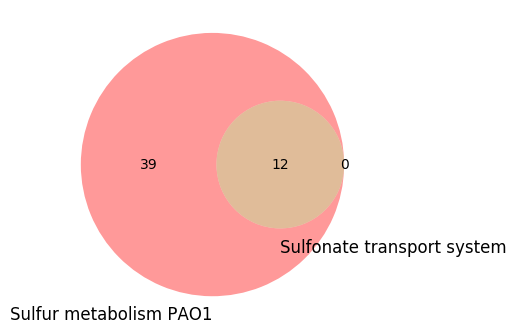

In [8]:
fig_3a = venn2(
    [SM_KEGG_definition, ST_KEGG_definition],
    set_labels=diagram_labels)
plt.show()

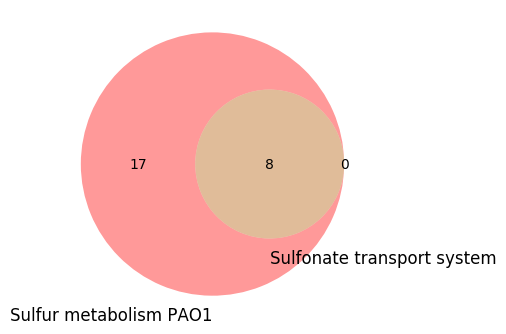

In [9]:
fig_3b = venn2(
    [SM_in_gene_signature, ST_in_gene_signature],
    set_labels=diagram_labels)
plt.show()

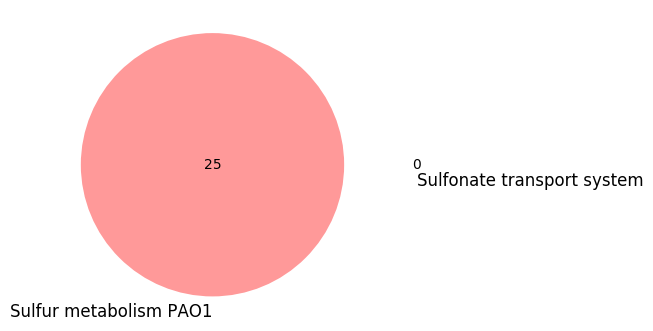

In [10]:
fig_3c = venn2(
    [SM_overlap_corrected_definition,
     ST_overlap_corrected_definition],
    set_labels=diagram_labels)
plt.show()

Run an enrichment analysis on the same feature with no overlap correction

In [11]:
feature_pathways_no_correction, analysis_no_correction = \
    pathway_enrichment_no_overlap_correction(
        weight_matrix_df[which_feature], pathway_definitions,
        GENE_SIGNATURE_DEFINITIONS["eADAGE"](std),
        metadata=True)
overlap_corrected_definitions = enrichment_analysis_details["pathway_definitions"]
feature_gene_signature = (enrichment_analysis_details["positive_signature"] |
                          enrichment_analysis_details["negative_signature"])

Build sub-networks from the two outputs for comparison

In [12]:
def add_feature_column(feature_df, feature):
    feature_df.loc[:, "feature"] = pd.Series(
        [feature] * len(feature_df.index), index=feature_df.index)
    return feature_df
significant_pathways_no_correction = add_feature_column(feature_pathways_no_correction, which_feature)
subnetwork_no_correction = CoNetwork(n_features, significant_pathways=significant_pathways_no_correction)

SM_adjacent = subnetwork_no_correction.get_adjacent_pathways(sulfur_metabolism)
ST_adjacent = subnetwork_no_correction.get_adjacent_pathways(sulfonate_transport)

SM_adjacent_exclude_ST = set(SM_adjacent) - set([sulfonate_transport])
ST_adjacent_exclude_SM = set(ST_adjacent) - set([sulfur_metabolism])

print("{0} pathways adjacent to {1}:".format(
        len(SM_adjacent_exclude_ST), sulfur_metabolism))
_ = [print("  {0}".format(x)) for x in SM_adjacent]
print()

print("{0} pathways adjacent to {1}:".format(
        len(ST_adjacent_exclude_SM), sulfonate_transport))
_ = [print("  {0}".format(x)) for x in ST_adjacent]

print()
print("(Excludes the connection between the two pathways.)\n")

common = SM_adjacent_exclude_ST & ST_adjacent_exclude_SM
print("{0} adjacent pathways in common between {1} and {2}".format(len(common), sulfur_metabolism, sulfonate_transport))

5 pathways adjacent to Sulfur metabolism PAO1:
  Sulfate-sulfur assimilation
  Sulfonate transport system
  Assimilatory sulfate reduction, sulfate => H2S
  Sulfate transport system
  Putative polar amino acid transport system
  NitT/TauT family transport system

5 pathways adjacent to Sulfonate transport system:
  Sulfate-sulfur assimilation
  Assimilatory sulfate reduction, sulfate => H2S
  Sulfate transport system
  Putative polar amino acid transport system
  NitT/TauT family transport system
  Sulfur metabolism PAO1

(Excludes the connection between the two pathways.)

5 adjacent pathways in common between Sulfur metabolism PAO1 and Sulfonate transport system


In [19]:
significant_pathways_with_correction = add_feature_column(feature_significant_pathways, which_feature)

subnetwork_with_correction = CoNetwork(n_features, significant_pathways=significant_pathways_with_correction)

SM_adjacent = subnetwork_with_correction.get_adjacent_pathways(sulfur_metabolism)

SM_adjacent_exclude_ST = set(SM_adjacent) - set([sulfonate_transport])

print("{0} pathways adjacent to {1}:".format(
        len(SM_adjacent_exclude_ST), sulfur_metabolism))
_ = [print("  {0}".format(x)) for x in SM_adjacent]
print()
print("Sulfonate transport is not in the overlap-corrected network: {0}".format(
    sulfonate_transport not in subnetwork_with_correction.edges))

1 pathways adjacent to Sulfur metabolism PAO1:
  Putative polar amino acid transport system

Sulfonate transport is not in the overlap-corrected network: True
